# Invisible Light - plotting a galaxy's colours

In this notebook, you will be able to use data from the LOFAR deep fields release to choose a galaxy and plot its _spectral energy distribution_ (SED)- that is, how bright the galaxy is across the electromagnetic spectrum. This data is from a well-studied field called the Lockman Hole, which is a patch of sky located in the constellation of Ursa Major. 

First we will import the Python libraries that we will use in this exercise:


In [27]:
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

Then we will import the data files. All of the data is publicly available on the LOFAR surveys website, but the data files are very large (> 1 GB!) so I'm using a short version of the table that I put together for my research. In astronomy, data is often stored in a file format called "fits" and one way to access it is to use the Astropy libary we imported above, which has a "fits" function to open such files.


In [28]:
data_file = fits.open("https://star.herts.ac.uk/~joanna/master_table.fits")

table = data_file[1].data
headers = data_file[1].header.keys

This data file is a table of data, with fluxes at several different wavelengths across the electromagnetic spectrum, from low frequency radio in LOFAR all the way through to optical and UV. If you print the variable "headers", you can see the names of all of the columns in the table. Some of these are a bit cryptic! They will be explained later.


In [29]:
print(headers)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  498 / length of dimension 1                          
NAXIS2  =                   53 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   81 / number of table fields                         
TTYPE1  = 'S2CLS name'                                                          
TFORM1  = '20A     '                                                            
TTYPE2  = 'Source_Name'                                                         
TFORM2  = '22A     '                                                            

Each row of the table is a different galaxy, and you can find its position on the sky by looking at the right ascension (RA) and declination (Dec) in the table, which are given with the keys 'RA_1' and 'Dec_1'.

Look up the coordinates of some of the galaxies in the table in [Aladin](https://aladin.u-strasbg.fr/AladinLite/)




In [30]:
n = 4 # You can change n to select any row of the table
galaxy = table[n-1] # Python starts counting at 0, so we subtract 1 from n

#~~~~~~~~~~~~~~~~~~~~~~~~
# Then we can print the coordinates of the galaxy you've chosen!
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f"Coordinates of galaxy {n}: {galaxy['RA_1']:0.07f}, {galaxy['Dec_1']:0.07f}")

Coordinates of galaxy 4: 161.7501250, 59.0187500


Here is a table that shows the different "bands" of the observations, the name of the column with the data for that band in the table, the units for the data in that column, and the wavelength that the band corresponds to.


<!-- "ugriz" is short for U-band, G-band, R-band, I-band, and Z-band, detailed on [the Wikipedia article on photometric systems](https://en.wikipedia.org/wiki/Photometric_system): -->
$$\begin{array}{|c|c|c|}
\hline \text{Band}                  & \text{Table key}        & \text{Units}       & \text{Wavelength}(\lambda)\\
\hline \text{u}                     & \text{'u_flux'}         & \text{microJy}     & \text{365 nm}\\
\hline \text{g}                     & \text{'g_flux'}         & \text{microJy}     & \text{475 nm}\\
\hline \text{r}                     & \text{'r_flux'}         & \text{microJy}     & \text{658 nm}\\
\hline \text{i}                     & \text{'i_rcs_flux'}     & \text{microJy}     & \text{806 nm}\\
\hline \text{z}                     & \text{'z_flux'}         & \text{microJy}     & \text{900 nm}\\
\hline \text{J}                     & \text{'J_flux'}         & \text{microJy}     & \text{1.24}\mu\text{m} \\
\hline \text{K}                     & \text{'K_flux'}         & \text{microJy}     & \text{2.19}\mu\text{m} \\
\hline \text{SWIRE channel 1}       & \text{'ch1_swire_flux'} & \text{microJy}     & \text{3.6}\mu\text{m} \\
\hline \text{SWIRE channel 2}       & \text{'ch2_swire_flux'} & \text{microJy}     & \text{4.5}\mu\text{m} \\
\hline \text{SWIRE channel 3}       & \text{'ch3_swire_flux'} & \text{microJy}     & \text{5.8}\mu\text{m} \\
\hline \text{SWIRE channel 4}       & \text{'ch4_swire_flux'} & \text{microJy}     & \text{8}\mu\text{m} \\
\hline \text{Spitzer MIPS}          & \text{'F_MIPS_24'}      & \text{microJy}     & \text{24}\mu\text{m} \\
\hline \text{Herschel PACS band 1}  & \text{'F_PACS_100'}     & \text{mJy}         & \text{100}\mu\text{m} \\
\hline \text{Herschel PACS band 2}  & \text{'F_PACS_160'}     & \text{mJy}         & \text{160}\mu\text{m} \\
\hline \text{Herschel Spire band 1} & \text{'F_SPIRE_250'}    & \text{mJy}         & \text{250}\mu\text{m} \\
\hline \text{Herschel Spire band 2} & \text{'F_SPIRE_350'}    & \text{mJy}         & \text{350}\mu\text{m} \\
\hline \text{Herschel Spire band 3} & \text{'F_SPIRE_500'}    & \text{mJy}         & \text{500}\mu\text{m} \\
\hline \text{SCUBA-2}               & \text{'S_850_deboost'}  & \text{mJy}         & \text{850}\mu\text{m} \\
\hline \text{JVLA 1.4 GHz}          & \text{'f_peak_1.4GHz'}  & \text{Jy}          & \text{1.4 GHz*} \\
\hline \text{GMRT 610 MHz}          & \text{'f_peak_610MHz'}  & \text{Jy}          & \text{610 MHz*} \\
\hline \text{JVLA 324 MHz}          & \text{'f_peak_324MHz'}  & \text{Jy}          & \text{324 MHZ*} \\
\hline \text{LOFAR}                 & \text{'f_peak_150MHz'}  & \text{Jy}          & \text{150 MHZ*} \\
\hline
\end{array}$$

\*note that the last few rows are measured in frequency, not wavelength! This is standard in radio astronomy, and since we are combining data from a number of different sources, we have to deal with this and convert everything into either wavelength or frequency.

In [52]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Fluxes is a list that contains all of the keys to the table for the fluxes we want:
#~~~~~~~~~~~~~~~~~~~~~~~~
fluxes = ['u_flux','g_flux','r_flux','i_rcs_flux','z_flux','J_flux','K_flux', 'ch1_swire_flux', 'ch2_swire_flux',\
          'ch3_swire_flux','ch4_swire_flux','F_MIPS_24','F_PACS_100','F_PACS_160', 'F_SPIRE_250','F_SPIRE_350',\
          'F_SPIRE_500','S_850_deboost','f_peak_1.4GHz','f_peak_610MHz','f_peak_324MHz','f_peak_150MHz']

#~~~~~~~~~~~~~~~~~~~~~~~~
# Flux scale is a list of the factors by which we have to multiply the fluxes to convert them to mJy
#~~~~~~~~~~~~~~~~~~~~~~~~
flux_scale = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1,1,1,1,1,1,1000,1000,1000,1000]


#~~~~~~~~~~~~~~~~~~~~~~~~
# Wavelengths is a list of all of the wavelengths of the data in metres, excepte the radio data
#~~~~~~~~~~~~~~~~~~~~~~~~
wavelengths = [365e-9,475e-9,658e-9,806e-9,900e-9,1.24e-6,2.19e-6,3.6e-6,4.5e-6,5.8e-6,8e-6,24e-6,100e-6,
              160e-6,250e-6,350e-6,500e-6,850e-6]


#~~~~~~~~~~~~~~~~~~~~~~~~
# Frequencies contains the frequencies of the radio data, which we convert to wavelength and add to the end 
# of the wavelengths list:
#~~~~~~~~~~~~~~~~~~~~~~~~
frequencies = [1.4e9,610e6,324e6,150e6]
radio_wlens = [3e8/nu for nu in frequencies]
wavelengths = wavelengths + radio_wlens


#~~~~~~~~~~~~~~~~~~~~~~~~
# SED is a list that contains the fluxes scaled to be in mJy
#~~~~~~~~~~~~~~~~~~~~~~~~
SED = np.array([galaxy[flux]*scale for flux,scale in zip(fluxes, flux_scale)])/np.array(wavelengths)



fit = interp1d(np.log10(wavelengths), np.log10(SED), fill_value='extrapolate', kind="cubic")



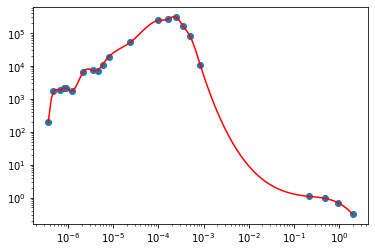

In [56]:
x = np.logspace(np.log10(wavelengths[0]), np.log10(wavelengths[-1]), 100)

fix, ax = plt.subplots()
ax.scatter(wavelengths, SED)
plt.plot(x, 10**fit(np.log10(x)), color="red")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
